# Topic Modeling with Latent Dirichlet Allocation (LDA) and MALLET

The following notebook walks you through doing LDA topic modeling in Python using the Gensim package MALLET wrapper. We then create an interactive visualization that can be saved as an html file and can therefore be embedded in a website or simply opened in your browser. 

### NOTE: In order to view the final interactive graph on GitHub you need to open this notebook in nbviewer. You can do this by clicking the "-" button in the upper right corner of this notebook.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/drafts/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.   

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download.

In your terminal, packages can be installed by typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:  

- **re:** Provides regular expression matching operations similar to those found in Perl.
- **json:** Allows for handling of data in JSON format.
- **os:** Provides a portable way of using operating system dependent functionality.
- **string:** Contains a number of functions to process standard Python strings.
- **csv:** Implements classes to read and write tabular data in CSV format.
- **nltk:** A leading platform for building Python programs to work with human language data.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
- **numpy:** a general-purpose array-processing package designed to efficiently manipulate large multi-dimensional arrays of arbitrary records without sacrificing too much speed for small multi-dimensional arrays. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **pprint:** Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter.
- **gzip:** Provides a simple interface to compress and decompress files
- **collections:** implements specialized container datatypes providing alternatives to Python?s general purpose built-in containers, dict, list, set, and tuple.
- **sklearn:**  Module for machine learning built on top of SciPy and distributed under the 3-Clause BSD license.
- **gensim:** Python library for topic modelling, document indexing and similarity retrieval with large corpora.
- **spacy:** A library for advanced Natural Language Processing in Python and Cython.
- **pyldavis:** Python library for interactive topic model visualization.
- **matplotlib:**  Produces publication quality 2D graphics for interactive graphing, scientific publishing, user interface development and web application servers targeting multiple user interfaces and hardcopy output formats.
- **logging:** Defines functions and classes which implement a flexible event logging system for applications and libraries.
- **warnings:** Allows for the manipulation of warning messages in Python.

In [2]:
import re
import json
from os.path import join, isfile, splitext
import string
import csv
import nltk
from nltk.corpus import stopwords
import glob
import numpy as np
import pandas as pd
from pprint import pprint
import gzip
from collections import Counter


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
#%matplotlib inline

# Import warning
import logging
import warnings

This will give more details regarding error messages and will also ignore deprecation and user warnings. All the deprecation and user warnings in this code are not concerning and will not break the code or cause errors in the results.

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

### Getting your data

#### File paths
Here we are saving as variables different file paths that we need in our code. We do this so that they are easier to call later and so that you can make most of your changes now and not need to make as many changes later. 

First we use the `os` package above to find our `[HOME]` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your "home" directory, so no changes are needed.

Next, we combine the `homePath` variable with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one file. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we add the `homePath` variable to other folder names that lead to a folder where we will want to save any output generated by this code. We will change the file names for our output in other cells as we need to down below. We save this file path as the variable `dataResults`.

Lastly, since we are using MALLET to do our LDA, you need to [download](http://mallet.cs.umass.edu/download.php) the MALLET zipfile, unzip it and provide the path to the extracted folder. We recommend saving the extracted folder in your "Carbonate" directory which is also your "home" directory. This way you will not need to adjust anything in the last line as it should point to the folder needed to run MALLET. We save this file path as the variable `malletPath`. 

In [4]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")
malletPath = os.path.join(homePath, "mallet-2.0.8", "bin", "mallet") # update this path

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. Much like the file path variables above, we do this so you do not need to make as many changes later.

**source**<br>
First, we need to decide if we want our code to read all the files in a directory or just a single file. If we want all the files in a directory then we set `source` equal to `"*"`. This means 'all' and will be added to the file type later in the code. If you want a single file change `"*"` to the file name without the ".txt" or ".csv" or ".json" at the end. So if you have a file named "myFile.txt" you would set `source` equal to `"myFile"` without the ".txt".

**fileType**<br>
Now we need to determine what file type our data is. You can find this by the file extension at the end of your file's name. Right now we can only read in plain text files which end in ".txt" (minus the quotes), comma separated value files which end in ".csv", and JSON files which end in ".json". So where it says `fileType =` inside the double quotes you need to put either `".txt"`, `".csv"`, or `".json"` depending on what your data file type is.

**docLevel**<br>
The `docLevel` variable is only for file types of ".txt" so if you have a ".csv" or ".json" you want to set it to **False** or it will cause problems in other parts of the code later since we do not keep track of file names for the ".csv" and ".json" files. If your data is in ".txt" format, then you need to determine if you want to chunk your corpus by line or by document.

We do this in case your data is a single ".txt" file. The LDA algorithm needs to have multiple chunks to accurately weigh and order words into topics. If you have multiple documents then the documents themselves are the chunks. If you have a single document, then we need to create chunks, and we do this by spliting the document up by line and each line is a separate chunk.

If you want to separate by document, then set docLevel equal to **True**. If you want to separate a line at a time and have each line be it's own entity or 'chunk' then set `docLevel` equal to **False**. If you set `source` equal to `"*"` then you will want to set `docLevel` equal to **True**. If you set `source` equal to a specific file name, then you will want to set `docLevel` equal to **False**.

**nltkStop**<br>
The `nltkStop` is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set `nltkStop` equal to **True**. If you do not, then set `nltkStop` equal to **False**.

**customStop**<br>
`customStop` is for if you have a .txt file that contains additional stopwords that you would like to read in and have added to the existing `stopWords` list. You do *NOT* need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopWords list.** If you have a list of your own then set `customStop` equal to **True**. If you do not have your own custom stopwords list then set `customStop` equal to **False**.

**spacyLem**<br>
`spacyLem` is where we decide if we want to use the spaCy package lemmatization function. What is lemmatization? Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. In computational linguistics, lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, where as stemming does not take the context of the word into account. For example, if we lemmatize the word "running" or "ran" it will become the word "run". If we stem the word "running" most stemmers will convert it to "runn" only removing the "ing" and leaving the second "n". Stemming will also change "police" and "policy" both to "polic" and they will be considered the same word by the LDA script. The lemmatizer will leave both words as "police" and "policy". This is useful and recommended for topic modeling as it allows the algorithm to just consider "walk" instead of "walking", "walked", and "walk" and thereby can increase the accuracy of your results. To use the spacy lemmatizer set `spacyLem` equal to **True**. If you do not wish to use the lemmatizer set `spacyLem` equal to **False**.

**stopLang**<br>
Now we choose the language we will be using for the nltk stopwords list. If you need a different language, simply change `'english'` (keep the quotes) in the `stopLang` variable to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you need to see the list of available languages in nltk simply remove the `#` from in front of `#print(" ".join(stopwords.fileids()))` on the last line and run the cell. A list of available languages will display below the cell.

**lemLang**<br>
Now we choose the language for our lemmatizer. The languages available for spacy include the list below and the abbreviation spacy uses for that language:

- **English:** en
- **Spanish:** es
- **German:** de
- **French:** fr
- **Italian:** it
- **Portuguese:** pt
- **Dutch:** nl
- **Multi-Language:** xx

To choose a language simply type the two letter code following the angliscized language name in the list above. So for Spanish it would be `'es'` (with the quotes) and for German `'de'` and so on.

**stopWords, docs, tweets**<br>
The `stopWords =[]` variable is simply an empty list. This is where the words from the nltk stopword list or your custom stopword list or both combined or neither (depending on what you decide) will reside later on. You do not need to do anything to this line of code.

The docs and tweets variables do not need to have anything done as they are also empty lists that have elements added to them later.

In [5]:
source = "*"
fileType = ".txt"
docLevel = True
nltkStop = True
customStop = True
spacyLem = True
stopLang = 'english'
lemLang = 'en'
stopWords = []
docs = []
tweets = []

#print(" ".join(stopwords.fileids()))

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the NLTK stopwords list to the empty list named `stopWords`.

You already chose your desired language above, so you do not need to do that now. 

If you need to add a few more words to the `stopWords` list that are specific to your dataset (such as common names or phrases that may make your results inaccurate), then add those to the `stopWords.extend(['would', 'said', 'says', 'also'])` part of the code in the square brackets with single quotes around each word and separated by a comma.

In [6]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))

    stopWords.extend(['would', 'said', 'says', 'also'])

#### Add own stopword list

Here is where your own stopwords list is added if you selected **True** in `customStop` above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct order always putting the file name including the file extension (.txt) last.

In [7]:
if customStop is True:
    stopWordsFilepath = os.path.join(homePath, "Text-Analysis-master", "data", "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Reading in .txt files
The code below reads in text files if you chose fileType `".txt"` above. It can do this in two ways. We can read in an entire directory, or we can read in a single file and it will do those based on what you chose for `source` above. Then it will chunk your data, either by document or by line, and this will depend on what you chose for `docLevel` above. 

In [8]:
if fileType == ".txt":
    paths = glob.glob(os.path.join(dataHome, "shakespeareDated", source + fileType))
    for path in paths:
        with open(path, "r", encoding = 'ISO-8859-1') as file:
             # skip hidden file
            if path.startswith('.'):
                continue
            if docLevel is True:
                docs.append(file.read().strip('\n').splitlines())
            else:
                for line in file:
                    stripLine = line.strip()
                    if len(stripLine) == 0:
                        continue
                    docs.append(stripLine.split())

### Reading in .csv files

If you chose `".csv"` as your `fileType` up above, then the code below reads in ".csv" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".csv" file depending on what you chose for `source` above. 

Once we have read in the ".csv" file using the Pandas `read_csv` function, we need to concatenate the ".csv" files if there are multiple. Because of this it is important that your ".csv" files have and identical column count and each column has identical header names or you will get errors. If you have a single ".csv" file then you should be fine for this step. We assign this process to the variable `cc_df` so we can use it later.

Now we convert our `cc_df` to a pandas dataframe. This allows for easier manipulation of the data in the next step.

The last line is where you will name the column you wish to convert to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. Here we are converting the column labeled `['text']` to a list. If you wished to convert the first column to a list the code would look like this: `tweets = cc_df[0].values.tolist()`. Notice the number is 0 and not 1. This is because Python begins counting at 0. 

In [9]:
if fileType == ".csv":
    all_files = glob.glob(os.path.join(dataHome, "twitter", source + fileType))     
    df_all = (pd.read_csv(f) for f in all_files)
    cc_df = pd.concat(df_all, ignore_index=True)
    cc_df = pd.DataFrame(cc_df, dtype = 'str')
    tweets = cc_df['text'].values.tolist()

### Reading in JSON files

If you chose `".json"` as your `fileType` up above, then the code below reads in ".json" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".json" file depending on what you chose for `source` above. 

Once we have read in the ".json" file we need to append the ".json" files if there are multiple. Because of this it is important that your ".json" files have identical keys or you will get errors. If you have a single ".json" file then you should be fine for this step. 

Next we append the contents to our empty `tweets=[]` list we created above. Then we convert our tweets list to a dataframe so we can more easily manipulate the data. Each key from the ".json" content is converted to a header in the dataframe and the values associated with that key now become rows in the corresponding column.

In the last line we now convert one column in our dataframe to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. Here we are converting the column labeled `['text']` to a list. If you wished to convert the first column to a list the code would look like this: `tweets = df[0].tolist()`. Notice the number is 0 and not 1. This is because Python begins counting at 0.

In [10]:
if fileType == ".json":
    for filename in glob.glob(os.path.join(dataHome, "twitter", "JSON", source + fileType)):
        with open(filename, 'r', encoding = "utf-8") as jsonData:
            for line in jsonData:
                tweets.append(json.loads(line))
    df = pd.DataFrame(tweets)
    tweets = df['text'].tolist()            

### Data variable

Now we need to change our variable containing our data (either docs or tweets from above) to the variable `data` since this is the variable used going forward and it saves you from having to switch between `tweets` and `docs` later in the code. If you read in ".csv" or ".json" files then your data is saved in the `tweets` list and if you read in ".txt" files then it is in the `docs` list. This code says if the length of the `docs` list is greater than 0 then assign `docs` to the variable data. If the length of `tweets` greater than 0 then assign `tweets` to the variable `data`.

If your data was in `tweets` then it most likely needs some additional cleaning. So the next chunk of code removes URLS and new line characters from the `data` variable if the length of `tweets` is greater than 0.

The last line prints out the first chunk of data in our collection, in this case the first few lines of the first item in our list of lists. If you are reading in a single document this will print the first line of your data. If you are reading in a line at a time this will print out each word for the entire text (either a single document or mutiple documents depending on your choices above) on it's own individual line.

In [11]:
if len(docs) > 0:
    data = docs
else:
    if len(tweets) > 0:
        data = tweets
        # Remove Urls
        data = [re.sub(r'http\S+', '', sent) for sent in data]
        # Remove new line characters
        data = [re.sub('\s+', ' ', sent) for sent in data]
for i in data:
    print(i[0])

 Cease to persuade, my loving Proteus.
 I'll feeze you, in faith.
 Hung be the heavens with black, yield day to night!
 As by your high imperial Majesty
 I wonder how the King escaped our hands.
 Noble patricians, patrons of my right,
 Now is the winter of our discontent
 Proceed, Solinus, to procure my fall,
 Let fame, that all hunt after in their lives,
 Old John of Gaunt, time-honored Lancaster,
 Now, fair Hippolyta, our nuptial hour
 Two households, both alike in dignity
 So shaken as we are, so wan with care,
 Now say, Chatillion, what would France with us?
 In sooth I know not why I am so sad.
 Open your ears, for which of you will stop
 Sir Hugh, persuade me not. I will make a
 I learn in this letter that Don
 As I remember, Adam, it was upon this
 Who's there?
 Hence! Home, you idle creatures, get you home!
 O, for a muse of fire that would ascend
 In Troy there lies the scene. From isles of Greece
 If music be the food of love, play on.
 Escalus.
 Tush, never tell me! I take i

### Tokenizing

This block of code separates each chunk of text into a list of individual words. In the process it also lower cases all the words and removes punctuation. If you wish to keep the punctuation change `deacc = True` to `deacc = False`.

In [12]:
def sentToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

dataWords = list(sentToWords(data))

for i in dataWords:
    print(i[:1])

['cease']
['ll']
['hung']
['as']
['wonder']
['noble']
['now']
['proceed']
['let']
['old']
['now']
['two']
['so']
['now']
['in']
['open']
['sir']
['learn']
['as']
['who']
['hence']
['for']
['in']
['if']
['escalus']
['tush']
['in']
['thought']
['good']
['nay']
['when']
['before']
['if']
['you']
['boatswain']
['come']


### Find Bigrams and Trigrams

This code will most likely not need to be adjusted. It creates a model of bigrams and trigrams in your dataset that occur frequently and then connects them with an underscore so the LDA algorithm will later consider them as one word. This is a good idea for items like 'new york' or 'new zealand' or 'Ho Chi Minh'. If we do not combine these frequently occuring phrases then 'new' and 'york' will be considered independently and give us less accurate results. 

Right now we have a `min_count` of 5 and a `threshold` of 100. The `min_count` is simply the minimum number of times the bigram or trigram needs to occur in order to be combined with an underscore. The `threshold` is a score that the bigram or trigram needs to exceed in order to be combined with an underscore. The score is determined by using this formula: (bigram_count - min_count)\*vocab_count/(wordA_count \* wordB_count). So let's say we have the bigram "good_lord" and it appears 30 times in a text of 10,000 words where "good" appears 60 times total and "lord" appears 40. With our `min_count` set to 5 we get the following: (30 - 5)\*10000/(60 \* 40) = 104.167 which means since our `threshold` is set to 100 "good_lord" will be combined with an underscore and made into a bigram. If the resulting score is above your `threshold` then the ngram is considered important enough to combine with an underscore and will be viewed as one word for the LDA scoring later. Therefore, if you increase the `threshold`, you will get fewer bigrams and trigrams. If our threshold was set to 110, then "good" and "lord" would not be combined into "good_lord".

The Phraser function takes the model you built with the Phrases function and cuts down memory consumption of Phrases, by discarding model state not strictly needed for the bigram detection task.

Lastly, we take a look at the ngrams created from the first item in our dataset only, so the results are for only one chunk, not the whole dataset. We do this by counting the number of words that contain an underscore as this is used to connect the words in the ngram together. **NOTE:** The output is only to test if the ngrams work so you will probably see ngrams containing stopwords. We will create a few functions next and then apply them to remove stopwords, create bigrams, and lemmatize the chunk.

In [13]:
# Build the bigram and trigram models
bigram = Phrases(dataWords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[dataWords], threshold=100)  

# Removes model state from Phrases thereby reducing memory use.
bigramMod = Phraser(bigram)
trigramMod = Phraser(trigram)

# See bigram/trigram example
testNgram = trigramMod[bigramMod[dataWords[0]]]
char = "_"
nGrams = [s for s in testNgram if char in s]
            
pprint(Counter(nGrams))

Counter({'thousand_times': 4,
         'good_morrow': 4,
         'chamber_window': 3,
         'fie_fie': 2,
         'an_ass': 2,
         'fast_asleep': 2,
         'gav_st': 1,
         'hard_favored': 1,
         'twenty_thousand': 1,
         'ill_favored': 1,
         'stand_aside': 1,
         'looking_glass': 1,
         'amen_amen': 1})


### Functions
We need to create a function in order to stem and tokenize our data. Any time you see `def` that means we are **DE**claring a **F**unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters required by the function. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to call the function without having to write out all the code in the function every time you wish to perform that task.

### Some functions

Below are functions we are creating that perform certain tasks. First we are creating a function to remove the stopwords that are in our stopword list we created previously. Then we create functions to apply our bigram and trigram code from above. 

Lastly, if you set `spacyLem` equal to **True** above then we will create the `lemmatization` function. If you set it equal to **False** then it will not create the function.

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def makeBigrams(texts):
    return [bigramMod[doc] for doc in texts]

def makeTrigrams(texts):
    return [trigramMod[bigramMod[doc]] for doc in texts]


if spacyLem is True:
    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        textsOut = []
        lemmaPOS = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            textsOut.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
            lemmaPOS.append([token.text and token.lemma_ and token.pos_ for token in doc if token.pos_ in allowed_postags])
        return textsOut
        print(lemmaPOS[:10])

Now we apply the functions. There are really only two parts where you may need to make changes and they are in the lines `dataWordsNgrams = makeBigrams(dataWordsNostops)` and `nlp = spacy.load(lemLang, disable=\['parser', 'ner'\])`.

The `dataWordsNgrams` variable is where you will change between either using the `makeBigrams` or `makeTrigrams` functions above. If you only want bigrams, then keep the code as it is. If you want both bigrams and trigrams to be considered in your topic modeling, then change the `makeBigrams` part to `makeTrigrams` and it will now calculate both bigrams and trigrams. 


Adjustments to the other line that might need changes mentioned above may only be necessary if you previously set `spacyLem` equal to **True**. Even if you set it to **True** you may still not need to make changes. The line of code you may want to change is `nlp = spacy.load('lemLang', disable=\['parser', 'ner'\])` and is where you can disable the parser and named entity recognizer (ner). 

If you wish for your words to be parsed simply remove `'parser'` from the `disable=` bracket. Same for `ner`. If you wish to use both the parser and ner then just remove the `, disable=\['parser', 'ner'\]` entirely (including the preceding comma), but leave the closing parantheses. The reason we disable to 'parser' and 'ner' is because they slow down the lemmatization process and are not necessary to lemmatize our dataset.

Lastly, we print out the ngrams we find in the first chunk (document or line) of our data. Notice there are no trigrams included. This is because we applied only the `makeBigrams` function from above. If we had applied the `makeTrigrams` function we would have both bigrams and trigrams. Feel free to change this in the code as described above. If we set `spacyLem` equal to **True** then we will get the first 10 words, their lemmatized form (which sometimes is identical to the word being lemmatized), with their parts of speech tagging from the `lemmatization` function above. Below this is a list of the lemmatized bigrams from the first chunk of our data. If we set it to **false** then we will get bigrams from the first chunk that have not been lemmatized.

In [15]:
# Remove Stop Words
dataWordsNostops = removeStopwords(dataWords)

# Form Bigrams
dataWordsNgrams = makeBigrams(dataWordsNostops)

if spacyLem is True:
    # Initialize spacy language model, eliminating the parser and ner components
    nlp = spacy.load(lemLang, disable=['parser', 'ner'])
    
    # Do lemmatization tagging only noun, adj, vb, adv
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    dataLemmatized = lemmatization(dataWordsNgrams, allowed_postags=allowed_postags)
    lemmaPOS = []
    for sent in dataLemmatized:
        lemmaNLP = nlp(" ".join(sent))
        for token in lemmaNLP:
            lemmaPOS.append([token.text, token.lemma_, token.pos_])
    print(lemmaPOS[:10])
    

    # Find ngrams and count number of times they occur
    dataNgrams = [s for s in dataLemmatized[0] if char in s]
    
else:
    dataNgrams = [s for s in dataWordsNgrams[0] if char in s]
print(Counter(dataNgrams))

[['cease', 'cease', 'VERB'], ['persuade', 'persuade', 'NOUN'], ['love', 'love', 'NOUN'], ['proteus', 'proteus', 'NOUN'], ['home', 'home', 'NOUN'], ['keep', 'keep', 'VERB'], ['youth', 'youth', 'NOUN'], ['homely', 'homely', 'ADV'], ['wit', 'wit', 'ADP'], ['affection', 'affection', 'NOUN']]
Counter({'good_morrow': 4, 'chamber_window': 3, 'fast_asleep': 2, 'gav_st': 1, 'fie_fie': 1, 'ill_favor': 1, 'stand_aside': 1, 'looking_glass': 1, 'amen_amen': 1})


### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

First, we need to determine if we are using lemmatized data or not. To do this we are using another `if` statement. Here, `if` we set `spacyLem` equal to **True** then we create the id2word dictionary based off of the lemmatized version of the data. However, if we did not, (denoted by `else`) then we will create the id2word dictionary based on the non-lemmatized data.

Gensim creates a unique id for each word in the document. For example, (0, 1) implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

In [16]:
if spacyLem is True:
    # Create Dictionary
    id2word = corpora.Dictionary(dataLemmatized)

    # Create Corpus
    texts = dataLemmatized
else:
    # Create Dictionary
    id2word = corpora.Dictionary(dataWordsNgrams)

    # Create Corpus
    texts = dataWordsNgrams
    
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [17]:
id2word[10]

'accord'

Or, you can see a human-readable form of the corpus itself.

In [18]:
# Human readable format of corpus (term-frequency)
hReadable = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
for i in hReadable:
    print(i[:10])

[('abbey', 1), ('abc', 1), ('abhor', 1), ('able', 1), ('abode', 1), ('abridge', 1), ('abroad', 1), ('absence', 1), ('access', 3), ('accomplish', 1)]


### USING MALLET

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. As long as you have [downloaded](http://mallet.cs.umass.edu/download.php) the MALLET zipfile, extracted it and provided the path to the extracted mallet folder in the `malletPath` variable in the cell where we assign file paths to variables towards the top, then you should be good. 

In the line of code, the only parts you will possibly change is "num_topics=20", "iterations=1000", and "random_seed = 42". These numbers determine the number of topic bins you want to use, the number of times you want to iterate through and run the LDA algorithm over your data, and the seed or version you want to use, respectively. 

The seed helps with reproducability so if someone else runs the code on your dataset with these settings they should get the same answer. **Note:** the topics will be the same, but possibly in a different order even when you set the seed, so if you run it and get a set of words for topic 5, then if you run it again with the exact same settings on the exact same dataset what was topic 5 might now be topic 12, but the topic will contain the same words ordered by weight/importance. 

Adjustments should be made according to your specific data set.

In [19]:
ldamallet = LdaMallet(malletPath, corpus=corpus, num_topics=20, id2word=id2word, workers = 1, iterations = 1000, random_seed = 42)

Now we display the "Top Ten" topics and the coherence score of the MALLET topics. The results show the topic number, the ten highest weighted (or important) keywords, and the weight score of those words. Finally, you get the coherence score.

The weight score may seem very low, however, when you consider that every word in your data makes up every topic then the words seem more important.

The coherence score is an algorithm that determines how 'human understandable' or 'coherent' your collection of topics are. We will do more with the coherence score further down in the notebook. For now, you should not need to make any changes.

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

if spacyLem is True:
    # Compute Coherence Score
    coherenceModelLdamallet = CoherenceModel(model=ldamallet, texts=dataLemmatized, dictionary=id2word, coherence='c_v')
    coherenceLdamallet = coherenceModelLdamallet.get_coherence()
else:
    # Compute Coherence Score
    coherenceModelLdamallet = CoherenceModel(model=ldamallet, texts=dataWordsNgrams, dictionary=id2word, coherence='c_v')
    coherenceLdamallet = coherenceModelLdamallet.get_coherence()
print('\nCoherence Score: ', coherenceLdamallet)

[(13,
  [('duke', 0.024501300954032957),
   ('cassio', 0.024284475281873375),
   ('brother', 0.019080659150043366),
   ('angelo', 0.016912402428447527),
   ('wife', 0.013876843018213356),
   ('moor', 0.013443191673894189),
   ('monster', 0.012792714657415438),
   ('soul', 0.011925411968777104),
   ('husband', 0.009540329575021683),
   ('dost', 0.009540329575021683)]),
 (0,
  [('father', 0.03561253561253561),
   ('master', 0.030626780626780627),
   ('daughter', 0.024691358024691357),
   ('love', 0.02184235517568851),
   ('kate', 0.01899335232668566),
   ('sister', 0.017331433998100665),
   ('valentine', 0.014957264957264958),
   ('sylvia', 0.01282051282051282),
   ('proteus', 0.012108262108262107),
   ('mad', 0.011870845204178538)]),
 (16,
  [('master', 0.04090623033354311),
   ('wife', 0.014317180616740088),
   ('pray', 0.012271869100062933),
   ('cousin', 0.010698552548772814),
   ('harry', 0.01038388923851479),
   ('john', 0.010069225928256766),
   ('shallow', 0.009911894273127754),


### FIND OPTIMAL NUMBER OF TOPICS

Next we will try and find the optimal number of topics. To do this we build many LDA models with different values of number of topics and pick the one that gives the highest coherence value. We do this by creating the function `computeCoherenceValues`. You will most likley not want to make changes to the function. Any possible changes will come in the next cell of code.

In [21]:
def computeCoherenceValues(dictionary, corpus, texts, limit, start=20, step=10):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    modelList : List of LDA topic models
    coherenceValues : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherenceValues = []
    modelList = []
    for numTopics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(malletPath, corpus=corpus, num_topics=numTopics, id2word=id2word)
        modelList.append(model)
        coherenceModel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherenceValues.append(coherenceModel.get_coherence())

    return modelList, coherenceValues

The `computeCoherenceValues()` trains multiple LDA models and their corresponding coherence scores. Right now we have it set to start with 20 topics and increase the number of topics by 10 every time and stopping at 80 topics. Notice that `limit` is set to 81, not 80. This is because the `limit` parameter is exclusive, meaning it includes everything before that number, but not the number itself. However, the `start` parameter is inclusive, so it includes the number we assign to that parameter. If we wanted to start at 30 topics and go up by 20 topics each time and stop at 90 topics as the max we would change the start, limit, and step numbers to `start=30, limit=91, step=20`. This is the only part of the code you may want to adjust depending on your needs.

**NOTE:** If you set `spacyLem` equal to **True** then make changes in the first line that starts `modelList, coherenceValues`. If you set `spacyLem` equal to **False**, then make changes in the second line that starts `modelList, coherenceValues`.

In [22]:
# Can take a long time to run.
if spacyLem is True:
    modelList, coherenceValues = computeCoherenceValues(dictionary=id2word, corpus=corpus, texts=dataLemmatized, start=20, limit=81, step=10)
else:
    modelList, coherenceValues = computeCoherenceValues(dictionary=id2word, corpus=corpus, texts=dataWordsNgrams, start=20, limit=81, step=10)

Now we want to visualize the coherence scores for each number of topics to help us decide how many topics we should use going forward. Here we need to make sure the limit, start, and step are the same as what we have in the previous code cell so that we can accurately see the coherence scores for each topic.

Choosing a number of topics that marks the end of a sharp increase in topic coherence scores usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the number of topics is too large. To choose the number of topics that might be best do not just use the highest coherence score. There are other factors that need to be considered. If the coherence score just seems to keep climbing higher and higher along with the number of topics, it might be best to find the number where it appears to stop and flatten out a bit before continuing to ascend. You do not want to run the risk of having too many or too few topics.

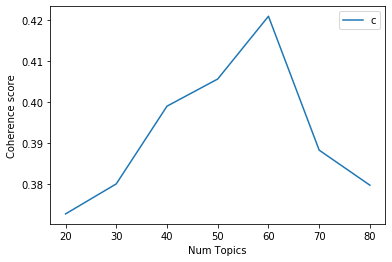

In [23]:
# Show graph
limit=81; start=20; step=10;
x = range(start, limit, step)
plt.plot(x, coherenceValues)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherenceValues"), loc='best')
plt.show()

Now that we have a visual, it may help to go back and look at the actuall numbers. The code below lists the coherence score for each number of topics we have selected. 

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherenceValues):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.3727
Num Topics = 30  has Coherence Value of 0.38
Num Topics = 40  has Coherence Value of 0.399
Num Topics = 50  has Coherence Value of 0.4056
Num Topics = 60  has Coherence Value of 0.421
Num Topics = 70  has Coherence Value of 0.3883
Num Topics = 80  has Coherence Value of 0.3797


Now we choose how many topics we want to work with going forward. To do this we count Pythonically (so starting with 0) and in the first line we choose the number of topics we want based on the order of where it falls in the list from the previous cell. So if we wish to keep using 20 topics, in the first line of code I would put `optimal_model = model_list[0]` which says I want to use the first item in the list called "model_list" which in this case is using 20 topics. If I wanted 60 topics I would change the [0] to a [4]. Pick whichever number of topics you think provides the best results for your data. We have it set to 20 (or number [0] in the list).

The second line of code says we want to see the topics and the weighted words associated with them as well as the weight of each word.

The final line of code says that we only want to see the top ten words based on their weight.

In [25]:
# Select the model and print the topics
optimalModel = modelList[0]
modelTopics = optimalModel.show_topics(formatted=False)
pprint(optimalModel.print_topics(num_words=10))

[(0,
  '0.017*"pray" + 0.015*"man" + 0.015*"jew" + 0.014*"ring" + 0.014*"lady" + '
  '0.014*"cardinal" + 0.013*"antonio" + 0.013*"choose" + 0.012*"fair" + '
  '0.012*"lord"'),
 (1,
  '0.035*"hector" + 0.021*"lord" + 0.021*"troilus" + 0.018*"troy" + '
  '0.018*"achille" + 0.017*"sweet" + 0.014*"ajax" + 0.014*"great" + '
  '0.012*"greek" + 0.010*"trojan"'),
 (2,
  '0.066*"lord" + 0.028*"king" + 0.021*"york" + 0.020*"duke" + 0.020*"henry" + '
  '0.017*"edward" + 0.015*"warwick" + 0.013*"god" + 0.012*"brother" + '
  '0.012*"grace"'),
 (3,
  '0.028*"lord" + 0.016*"love" + 0.016*"cassio" + 0.014*"die" + 0.011*"angelo" '
  '+ 0.010*"wife" + 0.010*"madam" + 0.010*"husband" + 0.009*"death" + '
  '0.009*"soul"'),
 (4,
  '0.020*"good" + 0.019*"make" + 0.018*"great" + 0.016*"hear" + 0.016*"speak" '
  '+ 0.015*"love" + 0.013*"time" + 0.012*"fear" + 0.012*"true" + '
  '0.011*"stand"'),
 (5,
  '0.037*"lord" + 0.036*"man" + 0.022*"god" + 0.016*"fool" + 0.012*"friend" + '
  '0.012*"good" + 0.012*"fortu

### Finding the dominant topic in each chunk

One of the practical applications of topic modeling is to take a chunk and determine what the dominant topic is for that chunk. To find that, we find the topic number that has the highest percentage contribution in that chunk. The `format_topics_sentences()` function below aggregates this information in a presentable table.

The table created gives the file name (but only if you set `docLevel` to **True** above), topic number of the most dominant topic for the chunk, percent contribution of that topic to that chunk, the keywords of the topic, and the beginning text of the chunk.

In [26]:
def formatTopicsSentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    
    sentTopicsDf = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topicNum, propTopic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topicNum)
                topicKeywords = ", ".join([word for word, prop in wp])
                sentTopicsDf = sentTopicsDf.append(pd.Series([int(topicNum), round(propTopic,4), topicKeywords]), ignore_index=True)
            else:
                break
    sentTopicsDf.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    if docLevel is True:
        txtPaths = pd.Series(os.path.basename(pathName) for pathName in paths)

        textPath = pd.Series(txtPaths)
        contents = pd.Series(texts)
        sentTopicsDf = pd.concat([textPath, sentTopicsDf, contents], axis=1)
        return(sentTopicsDf)
    else:
        contents = pd.Series(texts)
        sentTopicsDf = pd.concat([sentTopicsDf, contents], axis=1)
        return(sentTopicsDf)

Now we apply the function we just created. The only part of this you will need to change is the file name of the .csv file output of this table. This can be found in the beginning of the cell and is saved as the variable `domTopicPerChunkCSV`. Change the name of the file in quotes to whatever makes sense to you and fits your data.

If `docLevel` was set to **True** above then the code will add a column to the data frame for the file names. If it was set to **False** then it will not.

In [27]:
domTopicPerChunkCSV = 'domTopicPerChunk.csv'

dfTopicSentsKeywords = formatTopicsSentences(ldamodel=optimalModel, corpus=corpus, texts=data)

# Format
dfDominantTopic = dfTopicSentsKeywords.reset_index(drop=True)
if docLevel is True:
    dfDominantTopic.columns = ['Filename', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
else:
    dfDominantTopic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    
dfDominantTopic.to_csv(os.path.join(dataResults, domTopicPerChunkCSV))
# Show
dfDominantTopic

,Filename,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1589TwoGentlemenOfVerona.txt,8.0,0.2060,"master, love, mistress, father, home, wife, ge...","[ Cease to persuade, my loving Proteus., Home..."
1,1590TamingOfTheShrew.txt,8.0,0.3242,"master, love, mistress, father, home, wife, ge...","[ I'll feeze you, in faith., A pair of stocks..."
2,1591KingHenry6_1.txt,10.0,0.1924,"hand, heart, father, make, life, live, hast, m...","[ Hung be the heavens with black, yield day to..."
3,1591KingHenry6_2.txt,2.0,0.2514,"lord, king, york, duke, henry, edward, warwick...","[ As by your high imperial Majesty, I had in ..."
4,1591KingHenry6_3.txt,2.0,0.2864,"lord, king, york, duke, henry, edward, warwick...","[ I wonder how the King escaped our hands., , ..."
5,1591TitusAndronicus.txt,10.0,0.3662,"hand, heart, father, make, life, live, hast, m...","[ Noble patricians, patrons of my right,, Def..."
6,1592KingRichard3.txt,10.0,0.2212,"hand, heart, father, make, life, live, hast, m...","[ Now is the winter of our discontent, Made g..."
7,1594ComedyOfErrors.txt,8.0,0.2767,"master, love, mistress, father, home, wife, ge...","[ Proceed, Solinus, to procure my fall,, And ..."
8,1594LovesLaboursLost.txt,16.0,0.2805,"love, lady, man, sweet, wit, fair, fool, eye, ...","[ Let fame, that all hunt after in their lives..."
9,1595KingRichard2.txt,15.0,0.2675,"king, england, day, majesty, arm, blood, god, ...","[ Old John of Gaunt, time-honored Lancaster,, ..."


### Find the most representative chunk for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the chunk a given topic has contributed to the most and infer the topic by reading that chunk. The table created gives the chunk that is most representative of the topic, the topic number, percent contribution of that topic to that dchunk, the keywords of the topic, and the beginning text of the chunk.

The only part of this you will need to change is the file path where the .csv file output of this table will be saved. This can be found in the beginning of the cell and is saved as the variable `chunkRepCSV`. Change the name of the file in quotes to whatever makes the most sense for you and your data.

Again, if `docLevel` was set to **True** above then the code will add a column to the data frame for the file names. If it was set to **False** then it will not.

In [28]:
chunkRepCSV = 'chunkRepPerTopic.csv'

# Group top 5 sentences under each topic
sentTopicsSorteddfMallet = pd.DataFrame()

sentTopicsOutdfGrpd = dfTopicSentsKeywords.groupby('Dominant_Topic')

for i, grp in sentTopicsOutdfGrpd:
    sentTopicsSorteddfMallet = pd.concat([sentTopicsSorteddfMallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sentTopicsSorteddfMallet.reset_index(drop=True, inplace=True)

# Format
if docLevel is True:
    sentTopicsSorteddfMallet.columns = ['Filename','Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
else:
    sentTopicsSorteddfMallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    
sentTopicsSorteddfMallet.to_csv(os.path.join(dataResults, chunkRepCSV))

# Show
sentTopicsSorteddfMallet

,Filename,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1596MerchantOfVenice.txt,0.0,0.3217,"pray, man, jew, ring, lady, cardinal, antonio,...","[ In sooth I know not why I am so sad., It we..."
1,1600TroilusAndCressida.txt,1.0,0.3220,"hector, lord, troilus, troy, achille, sweet, a...",[ In Troy there lies the scene. From isles of ...
2,1591KingHenry6_3.txt,2.0,0.2864,"lord, king, york, duke, henry, edward, warwick...","[ I wonder how the King escaped our hands., , ..."
3,1603Othello.txt,3.0,0.2527,"lord, love, cassio, die, angelo, wife, madam, ...","[ Tush, never tell me! I take it much unkindly..."
4,1608Coriolanus.txt,4.0,0.3460,"good, make, great, hear, speak, love, time, fe...","[ Before we proceed any further, hear me, spe..."
5,1605TimonOfAthens.txt,5.0,0.4561,"lord, man, god, fool, friend, good, fortune, n...","[ Good day, sir., I am glad you're well., , ..."
6,1599Hamlet.txt,7.0,0.2801,"lord, hold, father, play, soul, follow, form, ...","[ Who's there?, , Nay, answer me. Stand and u..."
7,1590TamingOfTheShrew.txt,8.0,0.3242,"master, love, mistress, father, home, wife, ge...","[ I'll feeze you, in faith., A pair of stocks..."
8,1599JuliusCaesar.txt,9.0,0.3116,"caesar, antony, brutus, man, cassius, rome, ro...","[ Hence! Home, you idle creatures, get you hom..."
9,1591TitusAndronicus.txt,10.0,0.3662,"hand, heart, father, make, life, live, hast, m...","[ Noble patricians, patrons of my right,, Def..."


### Topic distribution across chunks

Next we want to understand the volume and distribution of topics in order to judge how widely it occurs in our data. The below table displays that information. 

This table tells the topic number, the topic keywords, the number of chunks that had this topic as its dominant topic, and what percent of the total number of chunks had this topic as the dominant topic.

The only part of this you will need to change is the file path where the .csv file output of this table will be saved. This can be found in the beginning of the cell and is saved as the variable `topicDistCSV`. Change the name of the file in quotes to whatever makes sense for you and your data.

In [29]:
topicDistCSV = 'domTopicCount.csv'

# Number of Documents for Each Topic
topicCounts = dfTopicSentsKeywords.groupby(['Dominant_Topic','Topic_Keywords']).size().to_frame('Num_Documents').reset_index()

# Percentage of Documents for Each Topic
topicContribution = round(topicCounts['Num_Documents']/topicCounts['Num_Documents'].sum(), 4)

# Concatenate Column wise
dfDominantTopics = pd.concat([topicCounts, topicContribution], axis=1)

# Change Column names
dfDominantTopics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
dfDominantTopics.to_csv(os.path.join(dataResults, topicDistCSV))
# Show
dfDominantTopics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"pray, man, jew, ring, lady, cardinal, antonio,...",1,0.0278
1,1.0,"hector, lord, troilus, troy, achille, sweet, a...",1,0.0278
2,2.0,"lord, king, york, duke, henry, edward, warwick...",2,0.0556
3,3.0,"lord, love, cassio, die, angelo, wife, madam, ...",1,0.0278
4,4.0,"good, make, great, hear, speak, love, time, fe...",7,0.1944
5,5.0,"lord, man, god, fool, friend, good, fortune, n...",1,0.0278
6,7.0,"lord, hold, father, play, soul, follow, form, ...",1,0.0278
7,8.0,"master, love, mistress, father, home, wife, ge...",3,0.0833
8,9.0,"caesar, antony, brutus, man, cassius, rome, ro...",1,0.0278
9,10.0,"hand, heart, father, make, life, live, hast, m...",3,0.0833


### Distribution of each topic across each chunk

This code creates a table that shows each document as well as the percentage of each topic within that document. This will only be implemented if `docLevel` was set to **True** above as it is really only useful at the document level.

There are two lines where changes will need to be made. They both follow directly after the commented line `#Variables`. The first line determines the name of the output .csv file that this table will be saved as. This is saved as the variable `docTopicsCSV`. Change the name of the file in quotes to whatever makes sense for you and your data. 

In the `sortOrder` variable you will need to change the `'topic_x'` to match whatever topic you wish to have the table orderd by (replacing the 'x' with the number of the topic, so `'topic_12'` or `'topic_0'`). This will allow you to see which documents in descending order have the highest percentage of your topic of interest. The syntax for the topic will always be `'topic_x'` as it is going by the column header. If you want it ordered by file name then put the `'Filenames'` column header first. The primary order will be by which ever column header comes first, with the second column header being a secondary ordering option. This means if we order it by `'topic_5'` first and then by `'Filnames'` second, the data frame rows will be in descending order based on the numbers in the column labeled `'topic_5'`, but in any cases where the numbers in `'topic_5'` are identical it will order those identical numbers by the corresponding contents of the `'Filenames'` column.

Again, this is only if you set `docLevel` to **True** above. The .csv file will contain the data based on the column you chose in the `sortOrder` variable. So the data will be sorted according to what topic (or the Filenames) you specified from the highest score to the lowest.

In [30]:
if docLevel is True:
    #Variables
    docTopicsCSV = 'docTopics.csv'
    sortOrder = ['topic_0','Filenames']
    
    docTopics = []
    for i in range(len(texts)):
        docTopics.append(optimalModel[corpus[i]])


    topicSeriesDf = pd.DataFrame([[y[1] for y in  x] for x in docTopics])


    txtPaths = pd.Series(os.path.basename(pathName) for pathName in paths)

    textPath = pd.Series(txtPaths)
    contents = pd.Series(texts)
    docTopicDis = pd.concat([textPath, topicSeriesDf], axis=1)

    docTopicsDf = docTopicDis.reset_index(drop = True)
    # get length of df's columns
    numCols = len(list(docTopicsDf))

    rng = range(0, (numCols) + 1)

    newCols = ['Filenames'] + ['topic_' + str(i) for i in rng]

    # ensure the length of the new columns list is equal to the length of df's columns
    docTopicsDf.columns = newCols[:numCols]

    sortedDf = docTopicsDf.sort_values(sortOrder, ascending = False)
    sortedDf.to_csv(os.path.join(dataResults, docTopicsCSV))

sortedDf

,Filenames,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
14,1596MerchantOfVenice.txt,0.321740,0.005816,0.001305,0.006217,0.163253,0.064608,0.001599,0.016104,0.011887,...,0.140159,0.000981,0.015625,0.083005,0.002078,0.008874,0.016490,0.014173,0.123507,0.001151
35,1612KingHenry8.txt,0.131133,0.000743,0.064507,0.004680,0.242026,0.066987,0.007650,0.014776,0.003427,...,0.086975,0.001778,0.018741,0.021303,0.002664,0.054534,0.002378,0.158546,0.115178,0.000688
13,1596KingJohn.txt,0.020791,0.000931,0.008053,0.002395,0.180378,0.019071,0.019071,0.031325,0.002125,...,0.195432,0.003874,0.032306,0.087861,0.007485,0.281538,0.005139,0.022966,0.076958,0.001343
23,1601TwelfthNight.txt,0.017451,0.007396,0.001097,0.022399,0.146285,0.117174,0.001465,0.061846,0.023435,...,0.107400,0.010011,0.045036,0.039245,0.002044,0.003167,0.203841,0.011590,0.169308,0.008203
1,1590TamingOfTheShrew.txt,0.015613,0.003307,0.003517,0.003032,0.126563,0.053453,0.001318,0.019640,0.323024,...,0.128552,0.014821,0.017893,0.077661,0.001577,0.002935,0.016583,0.019074,0.156916,0.013624
7,1594ComedyOfErrors.txt,0.015162,0.002552,0.005184,0.016352,0.107323,0.082973,0.004245,0.016604,0.274253,...,0.197311,0.001522,0.019991,0.087184,0.002117,0.006969,0.001545,0.013514,0.127875,0.016444
26,1604AllsWellThatEndsWell.txt,0.015009,0.010244,0.002247,0.132839,0.218412,0.133215,0.029243,0.020706,0.001901,...,0.088812,0.006020,0.006591,0.036549,0.001360,0.014032,0.030190,0.085716,0.161308,0.004487
0,1589TwoGentlemenOfVerona.txt,0.012434,0.000837,0.001368,0.001644,0.174720,0.064436,0.000857,0.018440,0.205968,...,0.199037,0.001211,0.003534,0.124392,0.004479,0.003180,0.083181,0.026454,0.064948,0.008142
19,1599Hamlet.txt,0.010779,0.004596,0.001371,0.019402,0.170156,0.062152,0.004392,0.279310,0.009188,...,0.108138,0.001661,0.069528,0.053066,0.002091,0.053561,0.002134,0.043046,0.100612,0.003564
17,1598MuchAdoAboutNothing.txt,0.009844,0.002793,0.002513,0.008526,0.122883,0.090772,0.002035,0.027473,0.011327,...,0.084396,0.045497,0.004160,0.110246,0.001030,0.005890,0.215904,0.002924,0.246911,0.003995


### Plot a stacked bar graph

This stacked bar graph shows the distribution of topics within a document. This will only be run if `docLevel` was set to **True** above as it is really only useful at the document level. That said, there are a few places where changes might need to be made. These can all be found in the four lines after the `#Variables` line. 

1. In the `graphName` variable you will want to change the name of the .png file to a name that fits better with your dataset.

2. The `boxSize` variable changes the size and dimensions of the legend box. The numbers indicate the following: (x, y, width, height). So the first two numbers determine where the legend resides in relation to the graph, and the third and fourth numbers determine how wide and high the legend box is. Feel free to play with these numbers to better fit your graph if needed.

3. In the `colorScheme` variable you may wish to change the color from `"Vega20"` to a different color scheme. Some options can be found [here](https://matplotlib.org/users/colormaps.html).

4. The next line which is the variable `topN` you may want to change the number depending on how many documents you wish to see. Right now we are diplaying the top 10, but you may only want 5 or 20. Adjust this number accordingly.

The rest of the code should not need to be adjusted.

In [31]:
if docLevel is True:
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    
    #Variables
    graphName = 'barGraphLDA.png'
    boxSize = (1.01,.5,.35,.5)
    colorScheme = "tab20"
    topN = min(10, len(sortedDf))
    
    colors = plt.cm.get_cmap(colorScheme)
    sortedDfSh = sortedDf[:topN]
    sortedDfSh = sortedDfSh.iloc[::-1]
    ax = sortedDfSh.plot(kind='barh', figsize = (10,2*topN), stacked = True, colormap = colors)
    ax.set_yticklabels(sortedDfSh['Filenames'], rotation=0)
    ax.tick_params(axis = 'y', which = 'major',labelsize = 24)
    lgd = ax.legend(bbox_to_anchor = boxSize, fontsize = 24)
    ax.figure.savefig(os.path.join(dataResults, graphName), dpi = 300, bbox_inches='tight')

### Making pyLDAvis work with MALLET
#### The code below was adapted from http://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/#topic=0&lambda=1&term= and was last accessed on 01/23/2019.

There should be no need to change any of the code that follows below until the last cell.

The first step is to extract the data from the MALLET statefile and put it into a pandas dataframe. We do this by creating two functions. One that extracts the parameters we need from the statefile and another that saves those parameters to a Pandas dataframe.

In [32]:
def extractParams(statefile):
    """Extract the alpha and beta values from the statefile.

    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        tuple: alpha (list), beta    
    """
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf8').strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(":")[1].split(" ")), float(params[1].split(":")[1]))


def stateToDf(statefile):
    """Transform state file into pandas dataframe.
    The MALLET statefile is tab-separated, and the first two rows contain the alpha and beta hypterparamters.
    
    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        datframe: topic assignment for each token in each document of the model
    """
    return pd.read_csv(statefile,
                       compression='gzip',
                       sep=' ',
                       skiprows=[1,2]
                       )

Now we look up the state file of the MALLET LDA results we saved as the variable `optimalModel` previously and save it as the variable `statefile`.

In [33]:
statefile = optimalModel.fstate()

In the next cell we run the `extractParams` function we created above and run it on our `statefile`. We then print out the parameters to make sure it works.

In [34]:
params = extractParams(statefile)

alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], 0.01


Now we apply the `stateToDf` function from above and create our dataframe containing the information from the MALLET statefile.

In [35]:
df = stateToDf(statefile)

Here we set the Python class (such as str, int, float, list, et cetera) for the entire column `['type']` to a string (str). This is because `nan` is used in Pandas to indicate missing integer values, and Pandas assumes it is an integer, rather than a string, so we change it to a string.

In [36]:
df['type'] = df.type.astype(str)

The next bit of data to gather is the length of the chunks. To do this, we group the data by the chunk id and count the tokens in the chunk. This data is sorted by the chunk id, so it is in the correct order for the visualization preprocessing. Then the dataframe is ordered using `reset_index` and this is indexing the dataframe by the column `'doc_length'`. The `reset_index` function will be used in a similar way later on.

In [37]:
# Get document lengths from dataframe
docs = df.groupby('#doc')['type'].count().reset_index(name ='doc_length')

Now we gather the vocabulary and frequencies. Here we use pandas to generate a new dataframe with the counts for each word. We then sort this dataframe so that it is alphabetical by type, a step we will repeat in creating the topic-term matrix later.

In [38]:
# Get vocab and term frequencies from dataframe
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)

Next is to create the matrix files. Here is where things get a bit tricky, as there is the adding of smoothing values and normalizing the data so that the percent distribution of each topic in each row sums to 1. To do the normalizing, we use sklearn because these are large matrices that require a more optimized function than dividing by the sum of the row with pandas.

In [39]:
# Topic-term matrix from state file
# https://ldavis.cpsievert.me/reviews/reviews.html
import sklearn.preprocessing

def pivotAndSmooth(df, smoothValue, rowsVariable, colsVariable, valuesVariable):
    """
    Turns the pandas dataframe into a data matrix.
    Args:
        df (dataframe): aggregated dataframe 
        smooth_value (float): value to add to the matrix to account for the priors
        rows_variable (str): name of dataframe column to use as the rows in the matrix
        cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable(str): name of the dataframe column to use as the values in the matrix
    Returns:
        dataframe: pandas matrix that has been normalized on the rows.
    """
    matrix = df.pivot(index=rowsVariable, columns=colsVariable, values=valuesVariable).fillna(value=0)
    matrix = matrix.values + smoothValue
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

Now, we need to aggregate the data from the statefile dataframe to get the number of topic assignments for each word in the documents. We aggregate by topic and word, count the number of times each word is assigned to each topic, and then sort the resulting dataframe alphabetically by word, so that it matches the order of the vocabulary frame.

Then we do this again, but focused on the documents and topics.

In [40]:
phiDf = df.groupby(['topic', 'type'])['type'].count().reset_index(name ='token_count')
phiDf = phiDf.sort_values(by='type', ascending=True)

phi = pivotAndSmooth(phiDf, beta, 'topic', 'type', 'token_count')

thetaDf = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name ='topic_count')

theta = pivotAndSmooth(thetaDf, alpha , '#doc', 'topic', 'topic_count')

Now that we have all of the data in place, we can queue that data up and pass it to the visualization library. Then we plot the pyLDAvis graph. 

First, you will want to make a change, which is the file name in the first line. Change the file name to match your data, but keep the .html file extention. This file can be opened in a web browser simply by double clicking on the file. The file can also be used to embed the graph in a webpage.

**NOTE:** In `n_jobs` you want to keep it equal to 1. Anything higher and ReD will give an error. If you are running this on your own computer then feel free to change this number to the number of cores on your computer or any number between 1 and the number of cores on your computer. If you remove the `n_jobs` variable then it will default to using all available cores.

The result is an interactive bubble and bar graph. The bubbles represent the topics and the topics (bubbles) that are closest in proximity to one another on the graph are the most similar. The larger the bubble, the more weight that topic has throughout the entire corpus. Note that the topic numbers in the bubble are off by 1 when compared to the topic numbers above. This is because the topic bubbles start counting at 1 while the topics above started counting at 0. So topic 1 in our bubble graph is the same as topic 0 from above, and topic 2 below is the same as 1 above and so on.

The bar graphs show the top 30 words (by estimated frequency within the topic) for the currently highlighted topic. The red part of the bar shows the estimated word frequency in that topic, while the blue shows the actual frequency throughout the entire corpus.

The visualization is interactive, so as you hover over and click on aspects of the visualization you will be shown additional information. Hovering over a bubble shows you the words associated with that topic ranked by estimated frequency. Clicking on the bubble makes that the default bubble when you are not hovering over other bubbles. In the bar graph if you hover over a word, it will show you which topics have that word in the top 30 estimated frequencies of words in that topic. It does this by removing the bubbles that do not contain the word in their top 30 and it changes the bubble size of the remaining bubbles so you can see in which topics that word had the highest estimated frequency. 

The slide bar over the bar graph that goes from 0 to 1 changes the lambda setting. What this does is give more importance to words that occur dispraportinately more often in that topic than in others. These are called "jargon" words. The closer you move the slider to 0, the more "jargon" words rise to the top of the bar graph. The default is to set the slider to 1 which will place more emphasis on the relevance of the word in relation to the whole corpus, and less on the uniqueness of the word to that topic. Recommendations vary as to the best setting, but most fall in a range between 0.4 and 0.6. 

In [41]:
ldaVisHTML = 'ldaVisMallet.html'
n_jobs = 1

dataMallet = {'topic_term_dists': phi, 
              'doc_topic_dists': theta,
              'doc_lengths': list(docs['doc_length']),
              'vocab': list(vocab['type']),
              'term_frequency': list(vocab['term_freq'])}

visData = pyLDAvis.prepare(**dataMallet,sort_topics = False, n_jobs = n_jobs)
pyLDAvis.save_html(visData, os.path.join(dataResults, ldaVisHTML))
pyLDAvis.display(visData)

## VOILA!!

Ackowledgements: This algorithm was adapted from the blog "Machine Learning Plus". Reference: Machine Learning Plus. Topic Modeling with Gensim (Python). Retrieved from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ on November 5, 2018.